In [54]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding,GRU,LSTM,Bidirectional,Dropout,Conv1D,MaxPooling1D
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn import metrics
import os
import seaborn as sns
from keras import regularizers

In [2]:
target_class = ['BEI', 'CAI', 'DOH', 'MSA', 'RAB', 'TUN']
max_features = 10000
max_len = 100
batch_size = 32
epochs = 10
train_file = '../../MADAR-SHARED-TASK-third-release-8Mar2019/MADAR-Shared-Task-Subtask-1/Dialect6/Training/post_clean'
dev_file = '../../MADAR-SHARED-TASK-third-release-8Mar2019/MADAR-Shared-Task-Subtask-1/Dialect6/Developing/post_clean'


In [3]:
def prepare_data(data_dir):
    labels = []
    texts = []
    
    for label_type in target_class:#categories
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname[-4:] != 'tore':
                f = open(os.path.join(dir_name, fname))
                texts.append(f.read())# add the sentences to text array
                f.close()
                if label_type == 'BEI':# which value to assign to every class
                    labels.append(0)
                elif label_type == 'CAI':# which value to assign to every class
                    labels.append(1)
                elif label_type == 'DOH':# which value to assign to every class
                    labels.append(2)
                elif label_type == 'MSA':# which value to assign to every class
                    labels.append(3)
                elif label_type == 'RAB':# which value to assign to every class
                    labels.append(4)
                elif label_type == 'TUN':# which value to assign to every class
                    labels.append(5)
    return texts, labels

In [4]:
def load_data(data_dir, maxlen,max_words, test= False ):
#train_directory
    
    labels = []
    texts = []
    #i = 0
    texts, labels = prepare_data(data_dir)
                

    tokenizer = Tokenizer(num_words=max_words,split=' ')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    data = pad_sequences(sequences, maxlen=maxlen)
    labels = np.asarray(labels)
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)
    # Split the data into a training set and a validation set
    # But first, shuffle the data, since we started from data
    # where sample are ordered (all negative first, then all positive).
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    x_data = data[:]
    if test:
        y_data = np.asarray(labels) 
    else:
        y_data = labels[:]
    y_data = to_categorical(y_data, num_classes=len(target_class))

    return x_data, y_data
    
    
# if _test: y_test = np.asarray(labels)
    



In [5]:
input_train, y_train = load_data(train_file,max_len,max_features)
input_test, y_test = load_data(dev_file,max_len,max_features,test= True)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)


Found 39658 unique tokens.
Shape of data tensor: (54000, 100)
Shape of label tensor: (54000,)
Found 9638 unique tokens.
Shape of data tensor: (6000, 100)
Shape of label tensor: (6000,)
input_train shape: (54000, 100)
input_test shape: (6000, 100)


# LSTM model 

In [70]:
def build_keras_model_LSTM(max_len, max_features):
    model = Sequential()
    model.add(Embedding(max_features, 300, input_length= max_len))
    #model.add(LSTM(32)) #GRU
    #bidirectional 
    model.add(Bidirectional(LSTM(32)))
    #model.add(layers.Bidirectional(
    #    layers.GRU(32), input_shape=(None, float_data.shape[-1])))

    model.add(Dropout(0.25))
    model.add(Dense(len(target_class), activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),
            activity_regularizer=regularizers.l1(0.01)))
    model.summary()
    #model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    
    return model

In [71]:
model_LSTM = build_keras_model_LSTM(max_len, max_features)
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history_LSTM = model_LSTM.fit(input_train, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    #validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    validation_split=0.2)

model = model_LSTM
history = history_LSTM

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 300)          3000000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                85248     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 390       
Total params: 3,085,638
Trainable params: 3,085,638
Non-trainable params: 0
_________________________________________________________________
Train on 43200 samples, validate on 10800 samples
Epoch 1/100
43200/43200 [==============================] - 59566s 1s/step - loss: 0.8896 - acc: 0.7484 - val_loss: 0.5520 - val_acc: 0.8693
Epoch 2/100
43200/43200 [==============================] - 978s 23ms/step 

# GRU model

In [65]:
def build_keras_model_GRU(max_len, max_features):
    model = Sequential()
    model.add(Embedding(max_features, 64, input_length= max_len))
    model.add(Dropout(0.25))
    model.add(GRU(32)) #GRU
    model.add(Dense(len(target_class), activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),
            activity_regularizer=regularizers.l1(0.01)))
    model.summary()
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    
    return model

In [66]:
model_GRU = build_keras_model_GRU(max_len, max_features)
history_GRU = model_GRU.fit(input_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    #validation_data=(x_val, y_val),callbacks=[early_stopping])
                    validation_split=0.2)
history = history_GRU
model = model_GRU


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 64)           640000    
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 198       
Total params: 649,510
Trainable params: 649,510
Non-trainable params: 0
_________________________________________________________________
Train on 43200 samples, validate on 10800 samples
Epoch 1/10
43200/43200 [==============================] - 133s 3ms/step - loss: 1.3128 - acc: 0.5974 - val_loss: 0.7395 - val_acc: 0.8455
Epoch 2/10
43200/43200 [==============================] - 134s 3ms/step - loss: 

# Combined layers

In [45]:
def build_keras_model_combined(max_len,max_features):
    embedding_size = 64#300

    # Convolution
    kernel_size = 5
    filters = 64
    pool_size = 4

    # LSTM
    lstm_output_size = 70

    # Training
    #batch_size = 32
    epochs = 10

    model = Sequential()
    model.add(Embedding(max_features, embedding_size, input_length=max_len))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_output_size))
    model.add(Dropout(0.25))
    model.add(Dense(len(target_class),activation='softmax',kernel_regularizer=regularizers.l1(0.01),
            activity_regularizer=regularizers.l1(0.01)))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    
    return model


In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model_comb = build_keras_model_combined(max_len, max_features)
history_comb = model_comb.fit(input_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    #validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    validation_split=0.2)
history = history_comb
model = model_comb

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 64)            20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 426       
Total para

# Ensemble Learning

In [67]:
def plot_show(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

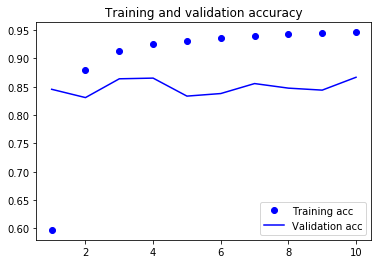

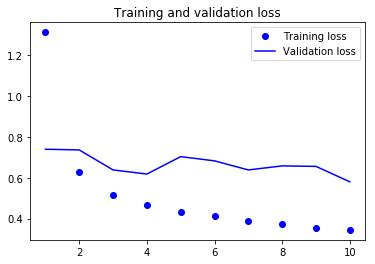

              precision    recall  f1-score   support

         BEI       0.14      0.17      0.15      1000
         CAI       0.16      0.15      0.16      1000
         DOH       0.22      0.16      0.19      1000
         MSA       0.18      0.17      0.18      1000
         RAB       0.15      0.17      0.16      1000
         TUN       0.17      0.19      0.18      1000

   micro avg       0.17      0.17      0.17      6000
   macro avg       0.17      0.17      0.17      6000
weighted avg       0.17      0.17      0.17      6000

Accuracy: 16.88%


In [68]:

plot_show(history)

scores= model.evaluate(input_test, y_test,verbose=0)
predicte = model.predict(input_test, verbose = 2, batch_size = batch_size)
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(predicte[:,:],axis=1),target_names = target_class))

print("Accuracy: %.2f%%" % (scores[1]*100))



In [49]:
def plot_confusion_matrix(score, cm, title='Confusion matrix', cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(score)))
    plt.xticks(tick_marks, score, rotation=45)
    plt.yticks(tick_marks, score)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

<function matplotlib.pyplot.show(*args, **kw)>

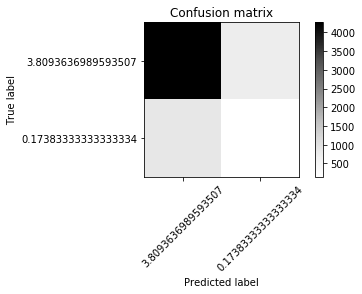

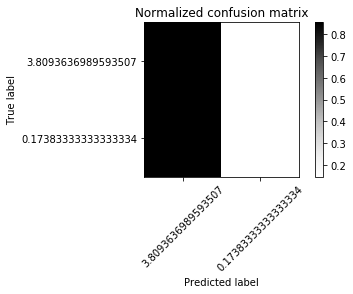

In [50]:
cm = metrics.confusion_matrix(y_test[:,1], np.round(predicte[:,1]))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(scores,cm).show    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(scores,cm_normalized, title='Normalized confusion matrix').show

#plt.show()


0.17383333333333334
[[125 169 134 233 157 182]
 [236 172 131 117 207 137]
 [133 205 172 131 153 206]
 [121 120 129 226 255 149]
 [166 122 114 210 178 210]
 [164 220 108 137 201 170]]
Accuracy: 17.38%


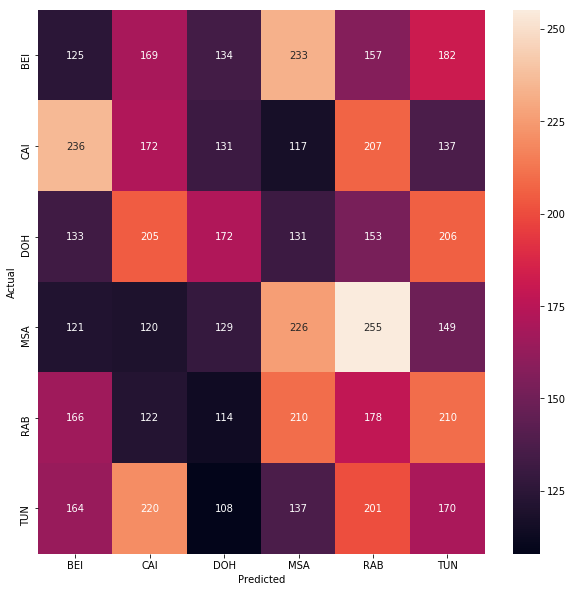

In [51]:
             

predicted = model.predict(input_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test.argmax(axis=1), predicted)
print(accuracy_score(y_test.argmax(axis=1), predicted))

matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predicted)
print(matrix)


scores= model.evaluate(input_test, y_test,verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


conf_mat = metrics.confusion_matrix(y_test.argmax(axis=1), predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=target_class, yticklabels=target_class)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()